In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
from concurrent.futures import ProcessPoolExecutor, Future
from itertools import product

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex3 src/Ex3_2024.cpp -std=c++17 -Wall -Wextra -Wuninitialized -O2 


src/Ex3_2024.cpp:48:59: warning: unused parameter 't' [-Wunused-parameter]
   48 |         valarray<double> get_f(const valarray<double>& x, double t) {
      |                                                                  ^
1 warning generated.


In [3]:
config_name = 'lagrange2'
conf = load_conf(config_name)

In [4]:
tFin = 20 * 365 * 24 * 60 * 60
tFin

630720000

In [5]:
# Position Lagrange 2
G = 6.674e-11
d = 149.598023e9
ms = conf['m1']
mt = conf['m2']
xs = -mt * d / (mt + ms)
xt = ms * d / (mt + ms)
Omega = np.sqrt(G * ms / (d**2 * xt))
Omega2 = Omega**2

coefs = [
    Omega2,
    -2 * Omega2 * (xs+xt),
    Omega2 * ((xt + xs)**2 + 2 * xt * xs),
    -(G * (ms + mt) + 2 * Omega2 * xt * xs * (xt + xs)),
    2 * G * (ms * xt + mt * xs) + Omega2 * xt**2 * xs**2,
    -G * (ms * xt**2 + mt * xs**2)
]
roots = np.roots(coefs)
assert roots[2].imag == 0.0
L2x = roots[2].real

In [6]:
def gen_variations(kwargs: dict[str, Any]) -> tuple[dict[str, Any], ...]:
    return tuple(
        {a: b for a, b in zip(kwargs.keys(), c)} for c in product(*kwargs.values())
    )

In [7]:
nsteps = np.linspace(2000, 20000, 100)
# params_variations = {
#     'nsteps': nsteps,
#     'adapt': ['true', 'false'],
# }
all_params = (
    *gen_variations({
        'nsteps': nsteps,
        'adapt': ('false',),
        'tFin': (tFin,),
    }),
    *gen_variations({
        'tol': np.geomspace(1e-3, 100000, 100),
        'adapt': ('true',),
        'tFin': (tFin,),
    }),
)

In [8]:
count = 0
def done(fut: Future) -> None:
    global count
    count += 1
    print(f'\rRunning simulations... Done {count}/{len(all_params)}', end='')

# Run simulations *IN PARALLEL*
outputs = []
with ProcessPoolExecutor(max_workers=8) as p:
    for params in all_params:
        options = stringify_dict(params)
        output_file = f"{data_path}{config_name},{options}.out"
        outputs.append(output_file)
        future = p.submit(run, f'{config_path}{config_name}{config_ext}', output_file, params)
        future.add_done_callback(done)

Running simulations... Done 200/200

In [9]:
# Load stuff in memory
all_data = {}
all_adapt = {}
all_fixed = {}

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data[file] = (params, data)
    match params.get('adapt'):
        case 'true':
            all_adapt[file] = (params, data)
        case 'false':
            all_fixed[file] = (params, data)
        case _:
            print("FEUR ALERT!!!", params)

# Plots!

42446.0


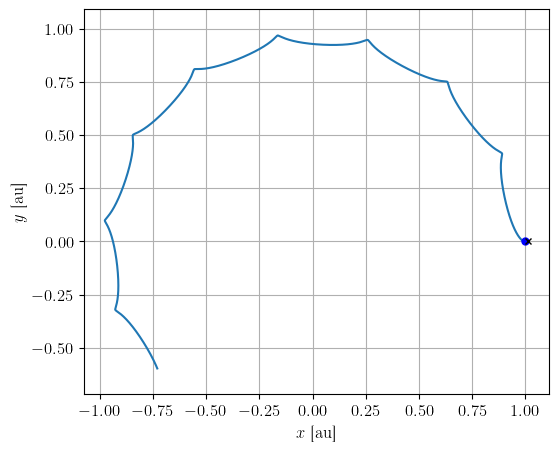

In [10]:
%matplotlib inline
# Do plots!
# plt.figure(figsize=(8, 8))

au = 1.495978707e11  # m / au

for i, (params, data) in enumerate(all_adapt.values()):
    if i != 0: continue
    t, x, y, vx, vy, ns = data[:,0], data[:,1] / au, data[:,2] / au, data[:,3], data[:,4], data[:,6]
    print(ns[-1])
    line, = plt.plot(x, y, '-', markersize=5)

# for i, (params, data) in enumerate(all_fixed.values()):
#     if i != len(all_fixed)-1: continue
#     t, x, y, ns = data[:,0], data[:,1] / au, data[:,2] / au, data[:,6]
#     print(ns[-1])
#     line, = plt.plot(x, y, '-', markersize=5)

# plt.plot(xs/au, 0, 'o', color='red', label='Soleil', markersize=5, zorder=2)
plt.plot(xt/au, 0, 'o', color='blue', label='Terre', markersize=5, zorder=2)
plt.plot(L2x/au, 0, 'x', color='black', label='L2', markersize=5, zorder=2)

plt.xlabel(r'$x$ [au]')
plt.ylabel(r'$y$ [au]')
plt.axis('equal')
# plt.legend()
plt.grid()

In [ ]:
xfs = np.zeros(len(all_fixed))
yfs = np.zeros(len(all_fixed))
nsfs = np.zeros(len(all_fixed))
emec_error = np.zeros(len(all_fixed))
for i, (params, data) in enumerate(all_fixed.values()):
    tf, xf, yf, nrj, nsf = data[-1,0], data[-1,1] / au, data[-1,2] / au, data[:,5], data[-1,6]
    xfs[i] = xf
    yfs[i] = yf
    nsfs[i] = nsf
    emec_error[i] = np.max(nrj) - np.min(nrj)

In [ ]:
plt.plot(nsfs, xfs, 'x-')

plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$x$ [au]')
plt.grid()

In [ ]:
plt.plot(nsfs, yfs, 'x-')

plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$y$ [au]')
plt.grid()

In [ ]:
xfs = np.zeros(len(all_adapt))
yfs = np.zeros(len(all_adapt))
nsfs = np.zeros(len(all_adapt))
emec_error = np.zeros(len(all_adapt))
for i, (params, data) in enumerate(all_adapt.values()):
    tf, xf, yf, nrj, nsf = data[-1,0], data[-1,1] / au, data[-1,2] / au, data[:,5], data[-1,6]
    xfs[i] = xf
    yfs[i] = yf
    nsfs[i] = nsf
    emec_error[i] = np.max(nrj) - np.min(nrj)

In [ ]:
plt.plot(nsfs, xfs, 'x-')

plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$x$ [au]')
plt.grid()

In [ ]:
plt.plot(nsfs**-5, yfs, 'x-')

plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$y$ [au]')
plt.grid()

In [ ]:
plt.plot(nsfs, emec_error)

plt.xlabel(r'$n_\textrm{steps}$')
plt.ylabel(r'$y$ [au]')
plt.grid()

In [ ]:
%matplotlib qt
import matplotlib.animation as mpla

plt.figure(figsize=(8, 8))

params, data = next(iter(reversed(all_fixed.values())))
t, xp, yp, ns = data[:,0], data[:,1], data[:,2], data[:,6]
x = xp * np.cos(Omega * t) - yp * np.sin(Omega * t)
y = xp * np.sin(Omega * t) + yp * np.cos(Omega * t)
line, = plt.plot(x[0], y[0], 'x-', markersize=5)
size = len(t)

terre, = plt.plot(xt, 0, 'o', color='blue', label='Terre', markersize=5, zorder=2)
soleil, = plt.plot(xs, 0, 'o', color='red', label='Soleil', markersize=5, zorder=2)
lagrange2, = plt.plot(L2x, 0, 'x', color='black', label='L2', markersize=5, zorder=2)

def animate(i) -> Any:
    idx = i % len(t)
    line.set_data(x[max(0, idx-5):idx], y[max(0, idx-5):idx])
    terre.set_data([xt * np.cos(Omega * t[idx])], [xt * np.sin(Omega * t[idx])])
    soleil.set_data([xs * np.cos(Omega * t[idx])], [xs * np.sin(Omega * t[idx])])
    lagrange2.set_data([L2x * np.cos(Omega * t[idx])], [L2x * np.sin(Omega * t[idx])])
    # plt.tight_layout()

anim = mpla.FuncAnimation(plt.gcf(), animate, interval=20, cache_frame_data=True, frames=1000)

plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')
plt.xlim(np.min(x)*1.1, np.max(x)*1.1)
plt.ylim(np.min(y)*1.1, np.max(y)*1.1)
plt.axis('equal')
# plt.legend()
plt.grid()